In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import dask
from dask.diagnostics import ProgressBar
from itertools import product
from joblib import Parallel, delayed
from collections import defaultdict

import common
import vcm
import fv3viz

In [2]:
grid = vcm.catalog.catalog["grid/c48"].to_dask()

In [3]:
def get_mse_bias(prediction, target, delp=None):
    diff = prediction - target
    dims = ["tile", "x", "y"]
    dims = set(diff.dims) & set(dims)
    bias = vcm.weighted_average(diff, grid.area, dims=dims)
    mse = vcm.weighted_average(diff ** 2, grid.area, dims=dims)

    if "z" in diff.dims and delp is not None:
        # do mass weighting
        print("Mass weighting variable.")
        delp = vcm.weighted_average(delp, grid.area, dims)
        wgt = delp / delp.sum("z")
        bias = (bias * wgt).sum("z")
        mse = (mse * wgt).sum("z")

    return mse, bias


def _get_pred_targ_keys(varname):
    base = "tendency_of_{varname}_due_to_zhao_carr_{source}"
    pr_base = "surface_precipitation_due_to_zhao_carr_{}"

    if "precipitation" in varname:
        return pr_base.format("emulator"), pr_base.format("physics")
    else:
        return (
            base.format(varname=varname, source="emulator"),
            base.format(varname=varname, source="physics")
        )

def _get_field_metrics(pred_ds, targ_ds, fields, key_func):

    ds = xr.Dataset()
    for f in fields:
        print(f"Processing variable metrics: {f}")
        p_key, t_key = key_func(f)
        delp = pred_ds["pressure_thickness_of_atmospheric_layer"]
        mse, bias = get_mse_bias(pred_ds[p_key], targ_ds[t_key], delp=delp)
        ds[f"mse.{f}"] = mse
        ds[f"bias.{f}"] = bias

    return ds

def get_all_vars_metrics(pred_ds, targ_ds):
    fields = ["air_temperature", "specific_humidity", "cloud_water", "surface_precipitation"]

    return _get_field_metrics(pred_ds, targ_ds, fields, _get_pred_targ_keys)


BIAS_FIELDS = [
        "air_temperature",
        "specific_humidity",
        "cloud_water_mixing_ratio",
        "total_precipitation",
        "h500",
        "USWRFtoa",
        "ULWRFtoa",
        "PWAT",
        "pressure_thickness_of_atmospheric_layer",
        "relative_humidity",
    ]

def get_all_baseline_metrics(online_ds, offline_ds):

    fields = BIAS_FIELDS

    return _get_field_metrics(online_ds, offline_ds, fields, lambda x: (x, x))

In [4]:
base_prefix = "zc-emu-monthly-normfix-m{init}-seed3-30d-v1"

In [5]:
def _open_group_pairs(prefix):

    online = common.open_group(f"{prefix}-online")
    offline = common.open_group(f"{prefix}-offline")

    online["relative_humidity"] = common.get_rh_from_ds(online)
    offline["relative_humidity"] = common.get_rh_from_ds(offline)

    return online, offline

groups = [base_prefix.format(init=f"{i:02d}") for i in range(1, 13)]
jobs = [delayed(_open_group_pairs)(g) for g in groups]
opened = Parallel(n_jobs=12)(jobs)

In [6]:
prefix_opened_map = {prefix: handles for prefix, handles in zip(groups, opened)}

In [7]:
client = dask.distributed.Client()

In [14]:
@common.memoize_xarray_out
def get_group_mse_bias_metrics_v4(group):

    online, offline = prefix_opened_map[group]

    ds = xr.Dataset()
    online_metr = get_all_vars_metrics(online, online)
    for k, v in online_metr.items():
        ds[f"online.{k}"] = v
    
    diag_metr = get_all_vars_metrics(online, offline)
    for k, v in diag_metr.items():
        if "mse" not in k:
            ds[f"diagnostic.{k}"] = v

    offline_metr = get_all_vars_metrics(offline, offline)
    for k, v in offline_metr.items():
        ds[f"offline.{k}"] = v

    return ds.load()


In [15]:
results = [
    get_group_mse_bias_metrics_v4(base_prefix.format(init=f"{i:02d}")) 
    for i in range(1, 13)
]

Processing variable metrics: air_temperature
Mass weighting variable.
Processing variable metrics: specific_humidity
Mass weighting variable.
Processing variable metrics: cloud_water
Mass weighting variable.
Processing variable metrics: surface_precipitation
Processing variable metrics: air_temperature
Mass weighting variable.
Processing variable metrics: specific_humidity
Mass weighting variable.
Processing variable metrics: cloud_water
Mass weighting variable.
Processing variable metrics: surface_precipitation
Processing variable metrics: air_temperature
Mass weighting variable.
Processing variable metrics: specific_humidity
Mass weighting variable.
Processing variable metrics: cloud_water
Mass weighting variable.
Processing variable metrics: surface_precipitation
Processing variable metrics: air_temperature
Mass weighting variable.
Processing variable metrics: specific_humidity
Mass weighting variable.
Processing variable metrics: cloud_water
Mass weighting variable.
Processing vari

In [19]:
to_concat = [ds.drop_vars("time") for ds in results]

In [20]:
ds = xr.concat(to_concat, dim="init")

In [21]:
dt = 900 # s
seconds_per_day = 60 * 60 * 24  # seconds/min * min/hr * hr/day
m_to_mm = 1000

# from physcons.f
cp = 1.0046e3 # J / (kg K)
gravity = 9.80665 # m / s^2|
lv = 2.5e6  # J / kg water
rho_water = 1000.0 # kg / m^3

def kg_m2_s_to_mm_day(da):
    return da * seconds_per_day / rho_water * m_to_mm

In [22]:
scale_factors = {
    "air_temperature": seconds_per_day, # seconds per day
    "specific_humidity": seconds_per_day * 1000,
    "cloud_water": seconds_per_day * 1000,
    "surface_precipitation": seconds_per_day / rho_water * m_to_mm,
}

units = {
    "air_temperature": "K/day", # seconds per day,
    "specific_humidity": "g/kg/day",
    "cloud_water": "g/kg/day",
    "surface_precipitation": "mm/day",
}

In [23]:
def plot_var_stats(ds, field):
    for_table = xr.Dataset()
    fig, ax = plt.subplots(1, 2, dpi=120, figsize=(8,4), constrained_layout=True)
    for k, v in ds.items():
        run, metric, f = k.split(".")
        da = ds[k]
        if field == f:
            if metric == "mse":
                da = np.sqrt(da)
                metric = "rmse"
                k = k.replace("mse", "rmse")
                da = da * scale_factors.get(field, 1)
                da.mean(dim="init").plot(label=f"{run}", ax=ax[0])
                ax[0].set_title(f"{field} {metric}")
                ax[0].set_ylabel(units[field])
                ax[0].legend()
            if metric == "bias":
                da = da * scale_factors.get(field, 1)
                da.mean(dim="init").plot(label=f"{run}", ax=ax[1])
                ax[1].set_title(f"{field} {metric}")
                ax[1].set_ylabel(units[field])
                ax[1].legend()
            da.attrs["units"] = units[field]
            for_table[k] = da
    plt.legend()
    plt.show()
    return for_table

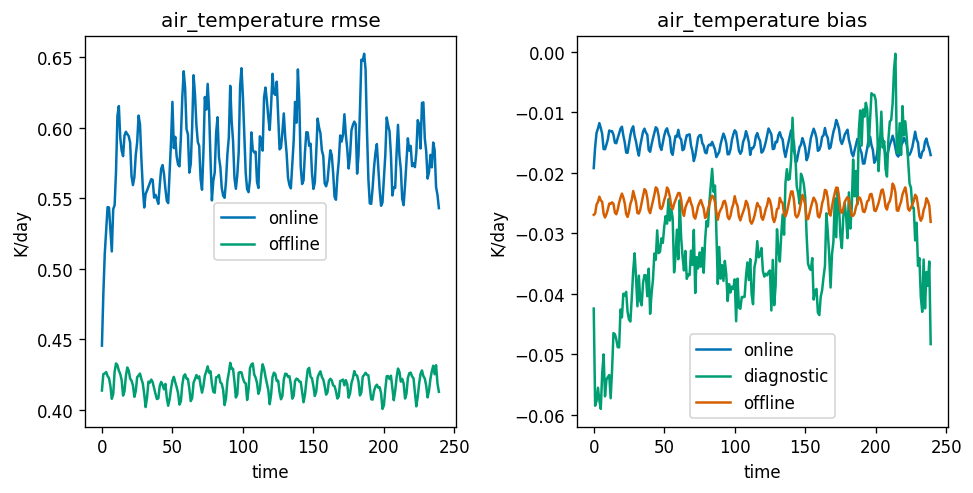

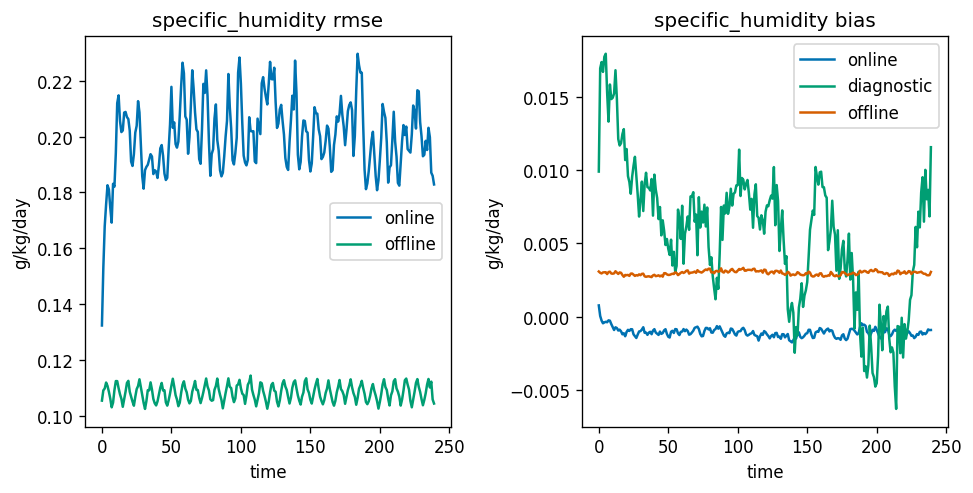

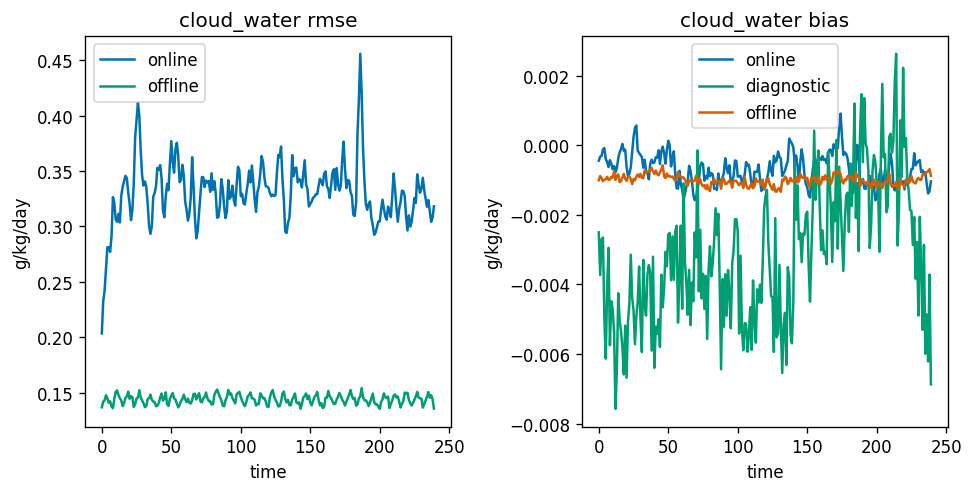

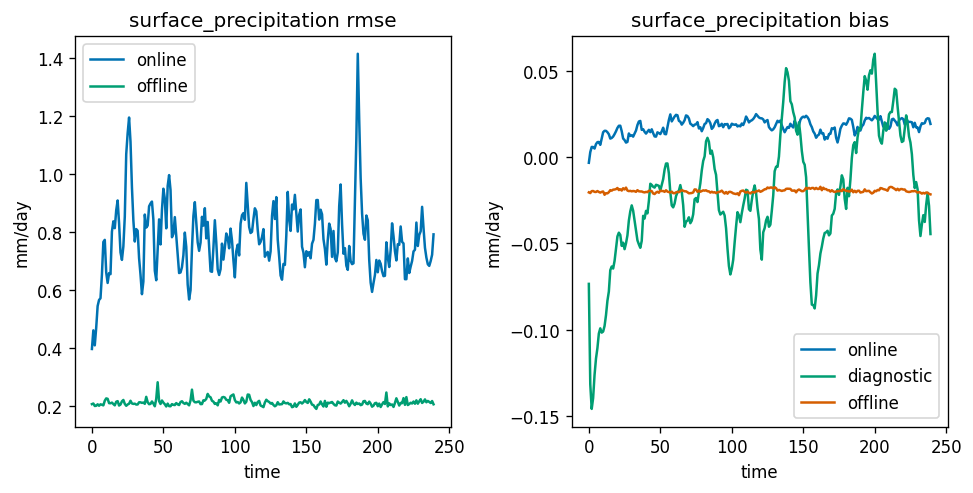

In [24]:

fields = ["air_temperature", "specific_humidity", "cloud_water", "surface_precipitation"]
metrics = xr.Dataset()
for field in fields:
    metrics = metrics.merge(plot_var_stats(ds, field))

In [25]:
metric_pd = metrics.transpose().mean(dim=["init", "time"]).to_pandas()

In [26]:
items = []
for idx, val in metric_pd.iteritems():
    run, metr, field = idx.split(".")
    items.append((field, run, metr, val))
new_df = pd.DataFrame(items, columns=["field", "run_type", "metric_name", "value"])



In [20]:
new_df.pivot(index=["run_type", "metric_name"], columns="field", values="value")

field                   air_temperature  cloud_water  specific_humidity  \
run_type   metric_name                                                    
diagnostic bias               -0.031536    -0.003154           0.005595   
offline    bias               -0.025342    -0.001002           0.002973   
           rmse                0.418935     0.143740           0.108331   
online     bias               -0.015031    -0.000680          -0.001071   
           rmse                0.581204     0.330636           0.200007   

field                   surface_precipitation  
run_type   metric_name                         
diagnostic bias                     -0.022310  
offline    bias                     -0.019664  
           rmse                      0.211918  
online     bias                      0.017589  
           rmse                      0.773997

In [21]:
new_df.pivot(index=["run_type", "metric_name"], columns="field", values="value").to_csv("bias_rmse.csv")

In [99]:
reload(common)

<module 'common' from '/home/andrep/repos/fv3net/projects/microphysics/docs/manuscript/common.py'>

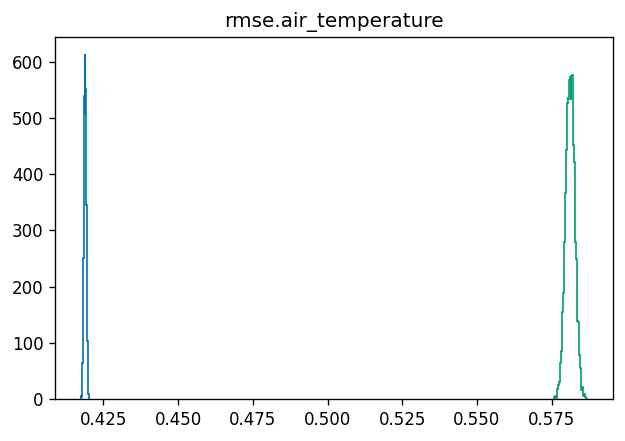

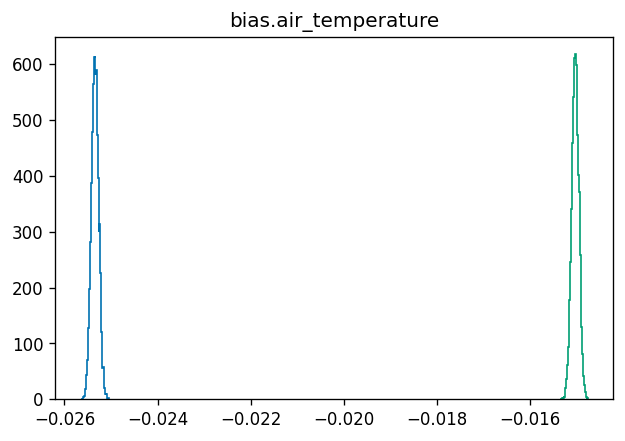

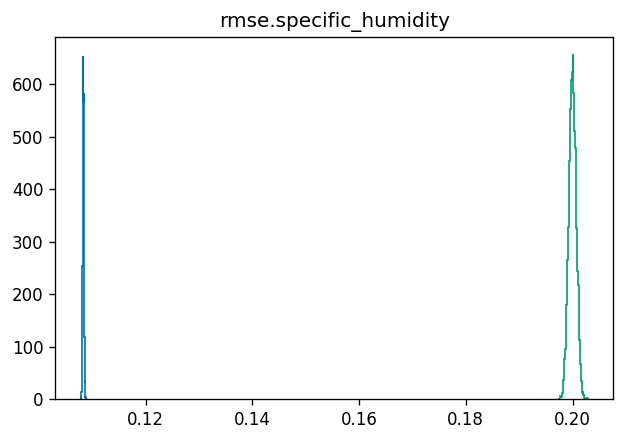

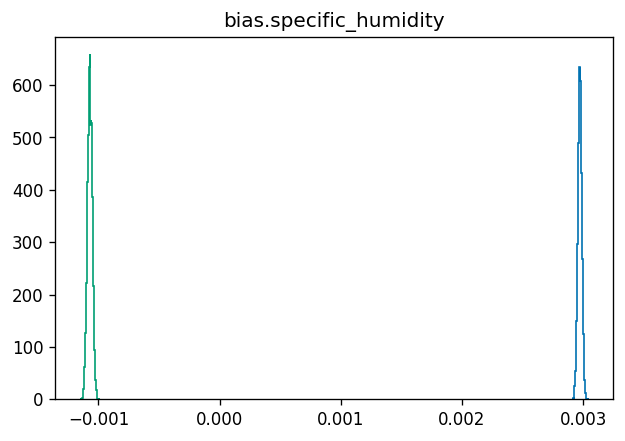

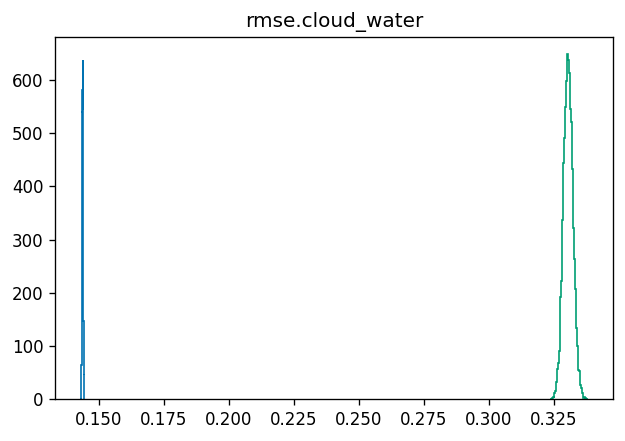

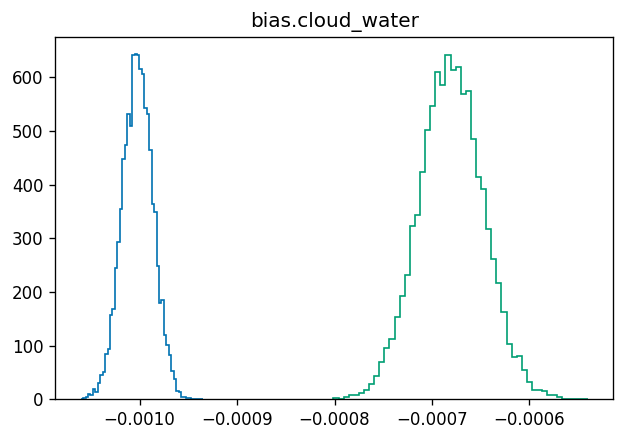

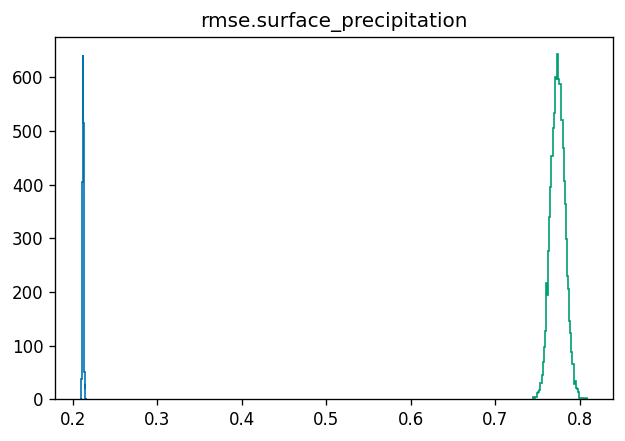

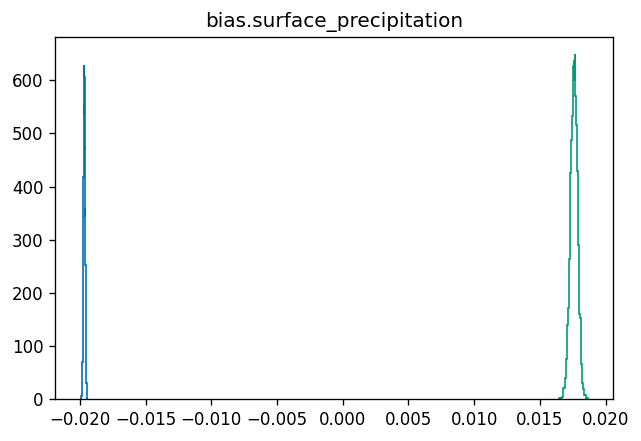

In [27]:
metric_signifs = {}
for k, v in metrics.items():
    if "offline" in k:
        onl_v = metrics[k.replace("offline", "online")]
        dists, signif = common.bootstrap_signif_two_metrics(v.values, onl_v.values)
        plt.figure(dpi=120)
        new_key = k.replace("offline.", "")
        plt.title(new_key)
        plt.hist(dists[0], bins=50, histtype="step", label="offline")
        plt.hist(dists[1], bins=50, histtype="step", label="online")
        plt.show()
        metric_signifs[new_key] = signif


In [28]:
pd.Series(metric_signifs)

rmse.air_temperature          True
bias.air_temperature          True
rmse.specific_humidity        True
bias.specific_humidity        True
rmse.cloud_water              True
bias.cloud_water              True
rmse.surface_precipitation    True
bias.surface_precipitation    True
dtype: bool

In [32]:
def limit_sigfigs(df, num_sigfigs=3):
    power_offset = -np.floor(np.log10(np.abs(df))).astype(int)
    to_round = df * 10.0 ** power_offset
    return to_round.round(num_sigfigs - 1) * 10.0 ** -power_offset

In [33]:
@common.memoize_xarray_out
def get_global_avg_v6(group, field, use_online):
    
    online, offline = prefix_opened_map[group]

    if use_online:
        ds = online
    else:
        ds = offline

    return vcm.weighted_average(ds[field], grid.area).load().to_dataset()
    


In [34]:
def get_glob_avgs(prefix):

    offline = []
    online = []
    for i in range(1, 13):
        group = prefix.format(init=f"{i:02d}")
        ds = xr.Dataset({f: get_global_avg_v6(group, f, False)[f] for f in BIAS_FIELDS})
        offline.append(ds.drop_vars("time"))
        ds = xr.Dataset({f: get_global_avg_v6(group, f, True)[f] for f in BIAS_FIELDS})
        online.append(ds.drop_vars("time"))

    offline = xr.concat(offline, dim="init")
    online = xr.concat(online, dim="init")

    return offline, online

In [35]:
baseline_avgs, online_avgs = get_glob_avgs(base_prefix)

In [36]:
baseline_avgs["net_outgoing"] = baseline_avgs["USWRFtoa"] + baseline_avgs["ULWRFtoa"]
online_avgs["net_outgoing"] = online_avgs["USWRFtoa"] + online_avgs["ULWRFtoa"]


In [37]:
off_wgt = baseline_avgs.pressure_thickness_of_atmospheric_layer / baseline_avgs.pressure_thickness_of_atmospheric_layer.sum(dim="z")
on_wgt = online_avgs.pressure_thickness_of_atmospheric_layer / online_avgs.pressure_thickness_of_atmospheric_layer.sum(dim="z")

Mass weighting air_temperature


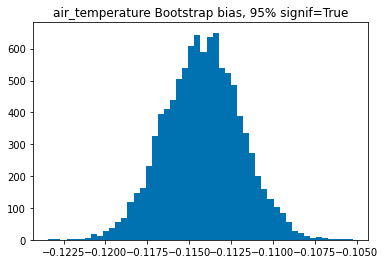

Mass weighting specific_humidity


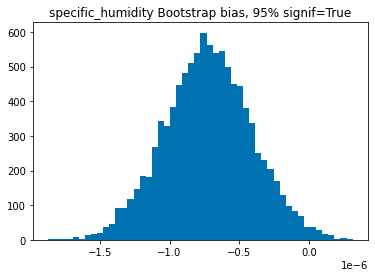

Mass weighting cloud_water_mixing_ratio


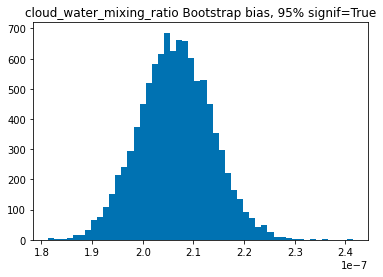

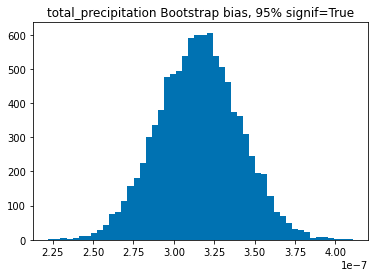

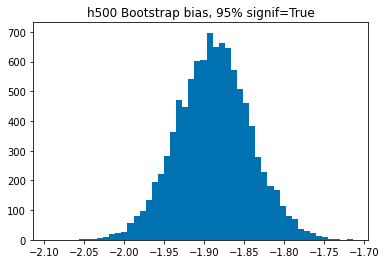

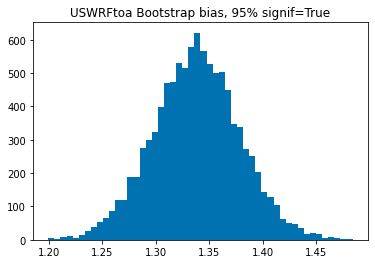

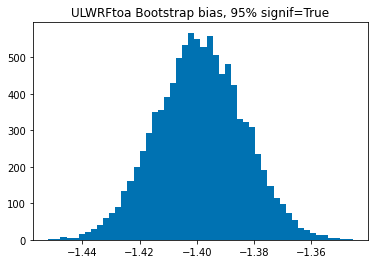

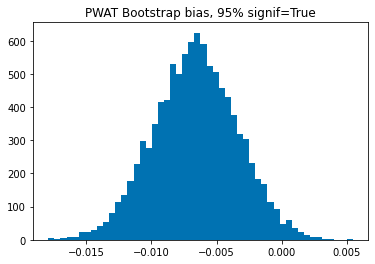

Mass weighting pressure_thickness_of_atmospheric_layer


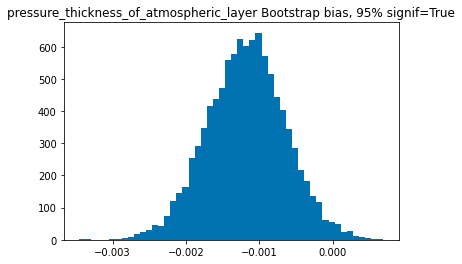

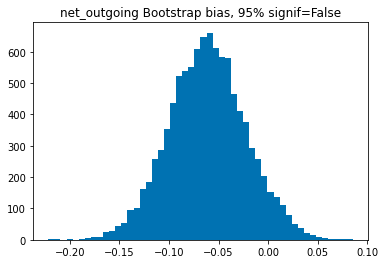

In [132]:

signifs = []
for k, da in online_avgs.items():
    if "z" in da.dims:
        print(f"Mass weighting {k}")
        off_values = (baseline_avgs[k]*off_wgt).sum("z").values.flatten()
        on_values = (da*on_wgt).sum("z").values.flatten()
    else:
        off_values = baseline_avgs[k].values.flatten()
        on_values = da.values.flatten()
        
    metric, signif = common.bootstrap_bias_signif((on_values - off_values))
    signifs.append(signif)
    plt.hist(metric, bins=50)
    plt.title(f"{k} Bootstrap bias, 95% signif={signif}")
    plt.show()


In [35]:
baseline_avgs

<xarray.Dataset>
Dimensions:                                  (z: 79, init: 12, time: 240)
Coordinates:
  * z                                        (z) float64 4.514 8.301 ... 998.3
Dimensions without coordinates: init, time
Data variables:
    air_temperature                          (init, time, z) float64 249.2 .....
    specific_humidity                        (init, time, z) float64 7.08e-06...
    cloud_water_mixing_ratio                 (init, time, z) float64 1.007e-2...
    total_precipitation                      (init, time) float64 2.963e-05 ....
    h500                                     (init, time) float32 5.631e+03 ....
    USWRFtoa                                 (init, time) float32 95.49 ... 9...
    ULWRFtoa                                 (init, time) float32 232.7 ... 2...
    PWAT                                     (init, time) float32 25.08 ... 2...
    pressure_thickness_of_atmospheric_layer  (init, time, z) float64 346.7 .....
    net_outgoing                             (init, time) float32 328.1 ... 3...

In [38]:
baseline_series = baseline_avgs.weighted(baseline_avgs.pressure_thickness_of_atmospheric_layer).mean().to_pandas()
baseline_series

air_temperature                             251.312464
specific_humidity                             0.002591
cloud_water_mixing_ratio                      0.000010
total_precipitation                           0.000032
h500                                       5660.707389
USWRFtoa                                     91.946347
ULWRFtoa                                    236.877356
PWAT                                         26.308177
pressure_thickness_of_atmospheric_layer    1455.318456
relative_humidity                             0.455096
net_outgoing                                328.823703
dtype: float64

In [39]:
baseline_series

air_temperature                             251.312464
specific_humidity                             0.002591
cloud_water_mixing_ratio                      0.000010
total_precipitation                           0.000032
h500                                       5660.707389
USWRFtoa                                     91.946347
ULWRFtoa                                    236.877356
PWAT                                         26.308177
pressure_thickness_of_atmospheric_layer    1455.318456
relative_humidity                             0.455096
net_outgoing                                328.823703
dtype: float64

In [40]:
online_avgs

<xarray.Dataset>
Dimensions:                                  (z: 79, init: 12, time: 240)
Coordinates:
  * z                                        (z) float64 4.514 8.301 ... 998.3
Dimensions without coordinates: init, time
Data variables:
    air_temperature                          (init, time, z) float64 249.2 .....
    specific_humidity                        (init, time, z) float64 7.08e-06...
    cloud_water_mixing_ratio                 (init, time, z) float64 1.007e-2...
    total_precipitation                      (init, time) float64 2.871e-05 ....
    h500                                     (init, time) float32 5.631e+03 ....
    USWRFtoa                                 (init, time) float32 95.67 ... 8...
    ULWRFtoa                                 (init, time) float32 232.6 ... 2...
    PWAT                                     (init, time) float32 25.09 ... 24.8
    pressure_thickness_of_atmospheric_layer  (init, time, z) float64 346.7 .....
    relative_humidity                        (init, time, z) float64 0.000166...
    net_outgoing                             (init, time) float32 328.3 ... 3...

In [41]:
baseline_bias = ( (online_avgs * on_wgt).sum("z") - (baseline_avgs * off_wgt).sum("z") ).mean().to_pandas()
bias_pct = (baseline_bias / baseline_series * 100).round(2)
bias_pct

air_temperature                           -0.05
specific_humidity                         -0.03
cloud_water_mixing_ratio                   2.15
total_precipitation                        1.00
h500                                      -0.03
USWRFtoa                                   1.45
ULWRFtoa                                  -0.59
PWAT                                      -0.03
pressure_thickness_of_atmospheric_layer   -0.00
relative_humidity                          1.79
net_outgoing                              -0.02
dtype: float64

In [42]:
out_df = pd.DataFrame()
out_df["Baseline avg."] = baseline_series
out_df["Online bias"] = baseline_bias
out_df["Pct change"] = bias_pct
out_df

,Baseline avg.,Online bias,Pct change
air_temperature,251.312464,-1.142005e-01,-0.05
specific_humidity,0.002591,-7.289450e-07,-0.03
cloud_water_mixing_ratio,0.000010,2.063585e-07,2.15
total_precipitation,0.000032,3.153312e-07,1.00
h500,5660.707389,-1.887785e+00,-0.03
USWRFtoa,91.946347,1.337382e+00,1.45
ULWRFtoa,236.877356,-1.398786e+00,-0.59
PWAT,26.308177,-6.689332e-03,-0.03
pressure_thickness_of_atmospheric_layer,1455.318456,-1.179573e-03,-0.00
relative_humidity,0.455096,8.142611e-03,1.79


In [41]:
out_df.to_csv("state_bias.csv")

In [45]:
names = {
    "air_temperature": "Air temperature [K]",
    "specific_humidity": "Specific humidity [g/kg]",
    "cloud_water_mixing_ratio": "Cloud water [g/kg]",
    "PWAT": "Precipitable water [kg/m$^2$]",
    "total_precipitation": "Surface precipitation [mm/day]",
    "USWRFtoa": "Upward shortwave at TOA [W/m$^2$]",
    "ULWRFtoa": "Upward longwave at TOA [W/m$^2$]",
    "net_outgoing": "Total outgoing radiation at TOA [W/m$^2$]",
    "h500": "500 hPa height [m]",
    "relative_humidity": "Relative humidity [%]",
}

scale_functions = {
    "specific_humidity": lambda x: x * 1000,
    "cloud_water_mixing_ratio": lambda x: x * 1000,
    "total_precipitation": common.m_to_mm_day,
    "relative_humidity": lambda x: x * 100,
}

bias_values = []
new_names = []
baseline_mean = []
pct_change = []
for key, new_name in names.items():
    scale_func = scale_functions.get(key, lambda x: x)
    bias_values.append(scale_func(baseline_bias[key]))
    baseline_mean.append(scale_func(baseline_series[key]))
    pct_change.append(bias_pct[key])
for_table = pd.DataFrame({"bias": bias_values, "baseline mean": baseline_mean, "pct_change": pct_change}, index=names.values())
for_table["bias"] = limit_sigfigs(for_table["bias"])
for_table["baseline mean"] = limit_sigfigs(for_table["baseline mean"])
for_table

,bias,baseline mean,pct_change
Air temperature [K],-0.114000,251.0000,-0.05
Specific humidity [g/kg],-0.000729,2.5900,-0.03
Cloud water [g/kg],0.000206,0.0096,2.15
Precipitable water [kg/m$^2$],-0.006690,26.3000,-0.03
Surface precipitation [mm/day],0.030300,3.0400,1.00
Upward shortwave at TOA [W/m$^2$],1.340000,91.9000,1.45
Upward longwave at TOA [W/m$^2$],-1.400000,237.0000,-0.59
Total outgoing radiation at TOA [W/m$^2$],-0.061400,329.0000,-0.02
500 hPa height [m],-1.890000,5660.0000,-0.03
Relative humidity [%],0.814000,45.5000,1.79


In [46]:
print(for_table.to_latex(formatters={"bias": lambda x: f"{x:1.2e}"}))

\begin{tabular}{lrrr}
\toprule
{} &      bias &  baseline mean &  pct\_change \\
\midrule
Air temperature [K]                       & -1.14e-01 &       251.0000 &       -0.05 \\
Specific humidity [g/kg]                  & -7.29e-04 &         2.5900 &       -0.03 \\
Cloud water [g/kg]                        &  2.06e-04 &         0.0096 &        2.15 \\
Precipitable water [kg/m\$\textasciicircum 2\$]             & -6.69e-03 &        26.3000 &       -0.03 \\
Surface precipitation [mm/day]            &  3.03e-02 &         3.0400 &        1.00 \\
Upward shortwave at TOA [W/m\$\textasciicircum 2\$]         &  1.34e+00 &        91.9000 &        1.45 \\
Upward longwave at TOA [W/m\$\textasciicircum 2\$]          & -1.40e+00 &       237.0000 &       -0.59 \\
Total outgoing radiation at TOA [W/m\$\textasciicircum 2\$] & -6.14e-02 &       329.0000 &       -0.02 \\
500 hPa height [m]                        & -1.89e+00 &      5660.0000 &       -0.03 \\
Relative humidity [\%]                     &  

In [ ]:
\begin{tabular}{lrr}
\toprule
{} &      bias &  baseline mean\\
\midrule
Air temperature [K]                       & -0.0114 &       251.0000 &       -0.05 \\
Specific humidity [g/kg]                  &  -7.29e-04 &         2.59 \\
Cloud water [g/kg]                        & 2.06e-04 &         0.0096 \\
Surface precipitation [mm/day]            & 0.0303 &         3.04 \\
Upward shortwave at TOA [W/m$^2$]         & -1.34 &        91.9 \\
Upward longwave at TOA [W/m$^2$]          &  1.40 &       237 \\
Total outgoing radiation at TOA [W/m$^2$] &  0.0614 &       329 \\
\bottomrule
\end{tabular}

